In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

sns.set_style('whitegrid')

In [60]:
df = pd.read_csv("./data/Price/Task 1/Task1_P.csv")

# cleaning
df.columns = ['zone_id','timestamp','system_load','zonal_load','price']
df['timestamp'] = df.timestamp.apply(lambda x: dt.strptime(x, '%m%d%Y %H:%M'))
df['day'] = df.timestamp.dt.date
df['hour'] = df.timestamp.dt.hour
df['weekday'] = df.timestamp.dt.weekday

# set main datetime index
df = df.set_index('timestamp')

In [96]:
def crps(x_hats, x, qs):
    """
    Continuous Ranked Probability Score
    Estimated using discretization of Pinball Scores at each quantile
    
    paramters:
    ----------
    x: float, the realization observed
    x_hats: array of float, the prediction of x at all q-th quantile from 1% to 99%
    qs: array of float, the q-th quantiles ∈ [0, 1] predictions provided
    """
    errors = np.abs(x - x_hats)
    weights = np.where(x >= x_hats, qs, 1-qs)
    return (errors * weights).sum()

def unconditional_coverage(y_true, y_lbs, y_ubs):
    """
    Unconditional Coverage of a quantile bound

    parameters:
    -----------
    y_true: array of float, the true observations
    y_lbs: array of float, the predicted lower bounds
    y_ubs: array of float, the predicted upper bounds
    """
    # remove any entry that is nan
    has_nan = np.isnan(y_true) | np.isnan(y_lbs) | np.isnan(y_ubs)
    is_covered = ((y_true >= y_lbs) & (y_true <= y_ubs))[~has_nan]
    return np.mean(is_covered)
    
# set up benchmark - naive
naive = df.copy()
naive['last_week_price'] = naive.shift(24*7).price
naive['last_day_price'] = naive.shift(24).price
naive['price_predict'] = naive.apply(lambda x: x.last_day_price if x.weekday in (1,2,3,4) else x.last_week_price, axis=1)

window_size = 182
qs = np.linspace(1, 99, 99) / 100

# rolling PI window estimation, done indepdently per hour
stats = []
for hour in range(24):
    window = naive[naive.hour==hour].rolling(window_size+1, min_periods=window_size+1)
    
    for chunk in window:
        ts = chunk.index[-1]

        # window chunk with not enough data
        if chunk.shape[0] != (window_size+1):
            stats.append((ts, np.nan, np.nan, np.nan))
            continue

        # chunk with enough data
        y_hat = chunk.price_predict.iloc[-1]
        chunk_history = chunk.iloc[:-1]
        y_hats = (chunk_history.price - chunk_history.price_predict).quantile(qs).values + y_hat

        y = chunk.price.iloc[-1]
        if np.isnan(y):
            stats.append((ts, y_hats[4], y_hats[94], np.nan))
        else:
            stats.append((ts, y_hats[4], y_hats[94], crps(y_hats, y, qs)))

naive[['predict_q5','predict_q95', 'crps']] = pd.DataFrame(stats, columns=['timestamp', 'predict_q5', 'predict_q95', 'crps']).set_index('timestamp')
naive['predict_uc'] = (naive.price <= naive.predict_q95) & (naive.price >= naive.predict_q5)

In [155]:
unconditional_coverage(naive.price, naive.predict_q5, naive.predict_q95)

0.8796037296037296

In [103]:
(naive.groupby('hour').crps.mean() / qs.shape[0]).mean()

3.0199095769595723

In [102]:
np.abs(naive.price - naive.price_predict).mean()

7.900679530201376

<AxesSubplot:xlabel='timestamp'>

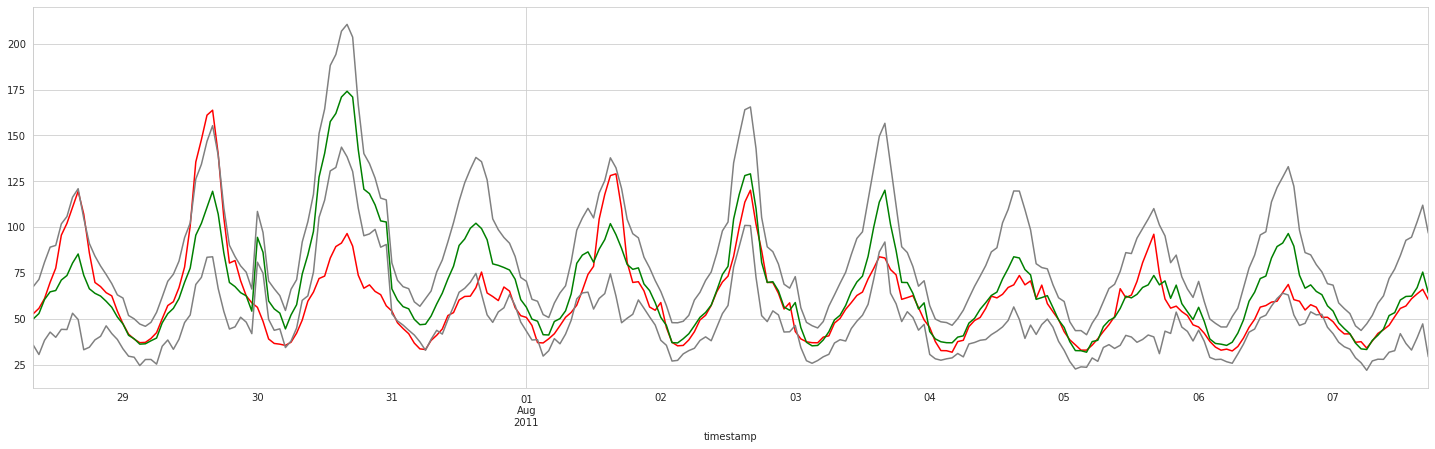

In [101]:
fig, ax = plt.subplots(figsize=(25, 7))
naive.iloc[5000:5250, :].price.plot(color='red')
naive.iloc[5000:5250, :].price_predict.plot(color='green')
naive.iloc[5000:5250, :].predict_q95.plot(color='grey')
naive.iloc[5000:5250, :].predict_q5.plot(color='grey')

<AxesSubplot:xlabel='zonal_load', ylabel='price'>

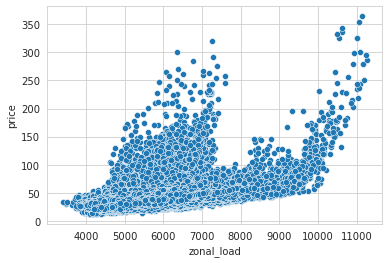

In [133]:
sns.scatterplot(data=df, x='zonal_load', y='price')

<AxesSubplot:xlabel='0', ylabel='Density'>

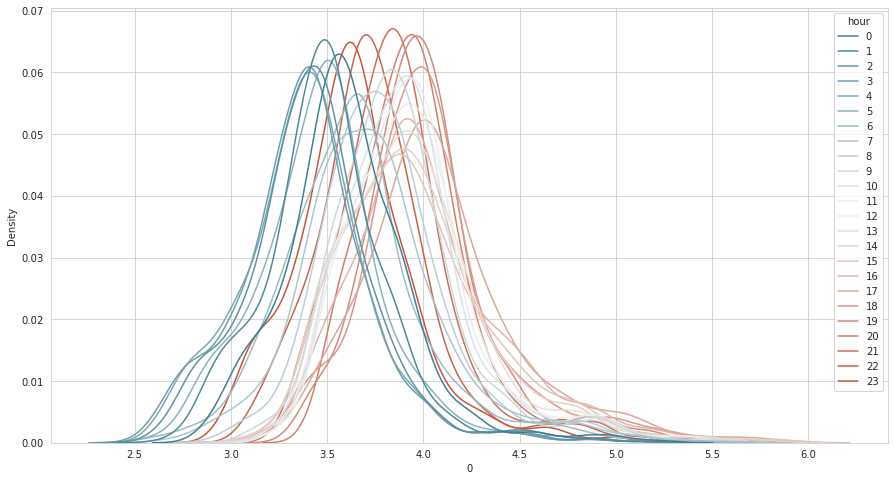

In [8]:
a = df.set_index(['day','hour']).loc[:, ['system_load','zonal_load','price']].unstack(level=1)

fig, ax = plt.subplots(figsize=(15, 8))
sns.kdeplot(data=np.log(a.price).stack().reset_index(), x=0, hue='hour', ax=ax, palette=sns.diverging_palette(220, 20, as_cmap=True))

<AxesSubplot:xlabel='hour', ylabel='0'>

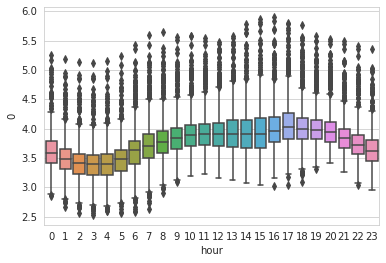

In [10]:
sns.boxplot(data=np.log(a.price).stack().reset_index(), y=0, x='hour')

<AxesSubplot:xlabel='hour', ylabel='hour'>

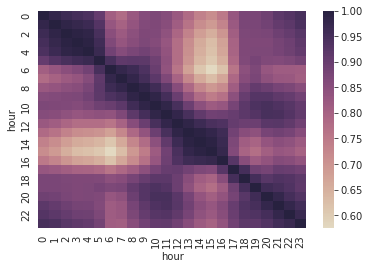

In [18]:
sns.heatmap(np.log(a.price).corr(), cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))

<AxesSubplot:xlabel='timestamp'>

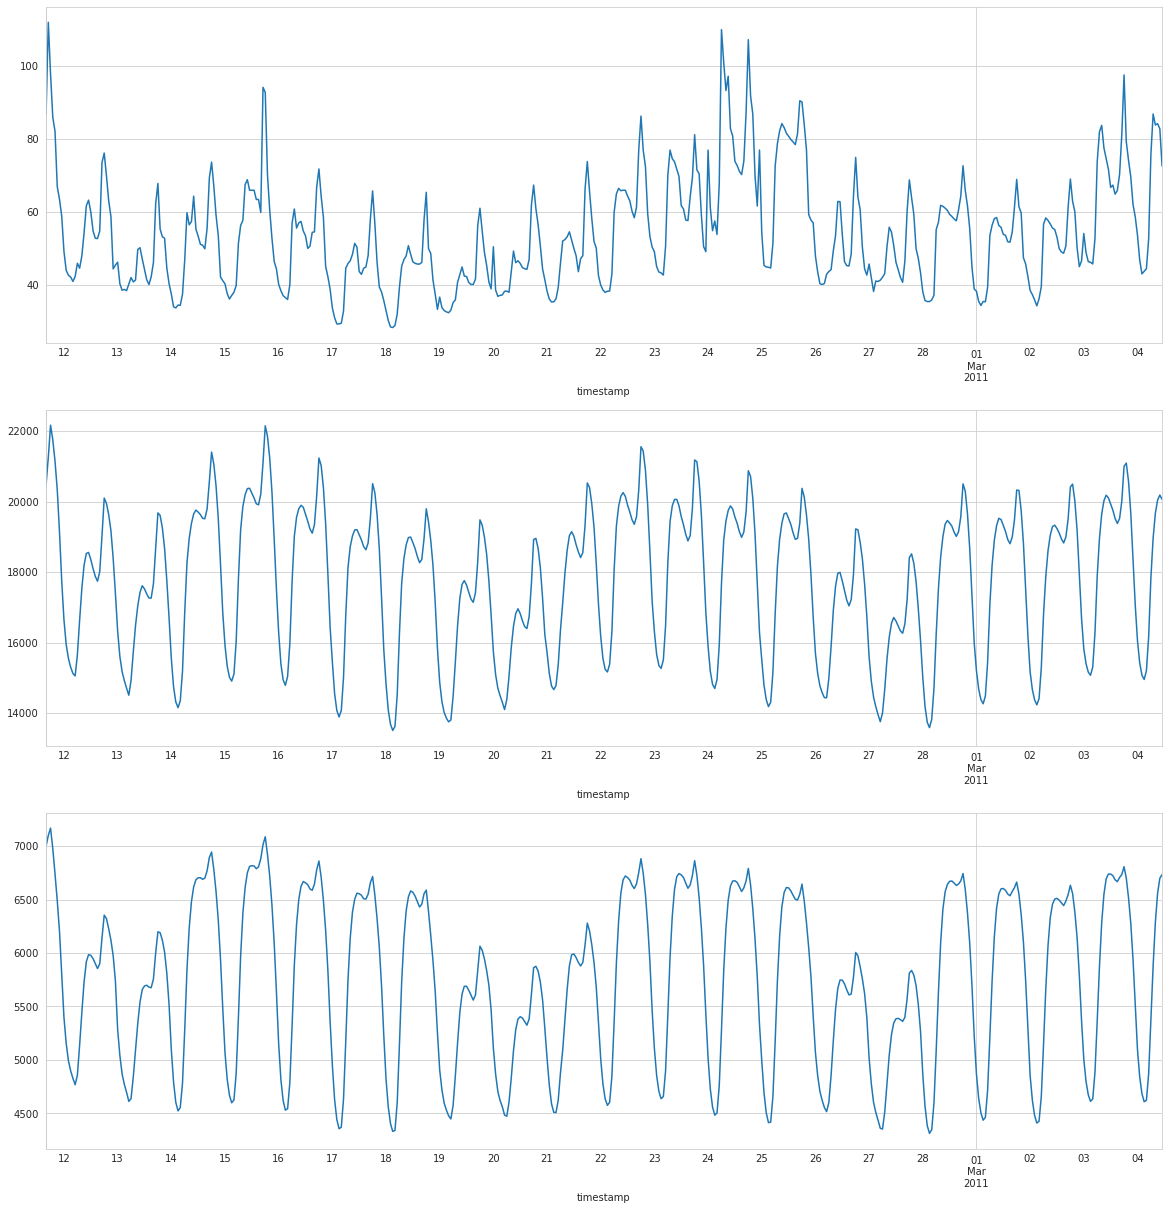

In [49]:
n1, n2 = 1000, 1500
fig, axes = plt.subplots(3, 1, figsize=(20, 21))
df.iloc[n1:n2, :].price.plot(ax=axes[0])
df.iloc[n1:n2, :].system_load.plot(ax=axes[1])
df.iloc[n1:n2, :].zonal_load.plot(ax=axes[2])